In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from PIL import Image
import itertools
import copy

from Trainer import ModelTrainer

In [2]:
# The size of our mini batches
batch_size = 64

# How many itterations of our dataset
num_epochs = 30

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from 
data_set_root = "../../datasets"

# What to resize our images to 
image_size = 96

In [3]:
start_from_checkpoint = False

save_dir = '../data/Models'
model_name = 'ResNet18_STL10_Rotate'

In [4]:
# Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### DataSets

In [5]:
# Create a STL10 dataset by inheriting Pytorch's exisitng STL10 
# and re-defining the __getitem__ method
class RotateSTL10(datasets.STL10):
    # Define a list of different angles to roate the image by
    all_perms = [0, 45, 90, 135, 180, 225, 270]
    
    def __getitem__(self, index):
            # Select image using index
            img = self.data[index]
            
            # doing this so that it is consistent with all other datasets
            # to return a PIL Image
            img = Image.fromarray(np.transpose(img, (1, 2, 0)))
            
            # Randomly select an angle from the list to rotate the image by
            rand_int = random.randint(0, len(self.all_perms) - 1)
            img = FT.rotate(img, angle=self.all_perms[rand_int])

            # Add additional transforms
            if self.transform is not None:
                img = self.transform(img)

            # Return roated image and the index of the selected angle
            return img, rand_int

In [6]:
# Create a STL10 dataset by inheriting Pytorch's exisitng STL10 
# and re-defining the __getitem__ method
class ShuffleSTL10(datasets.STL10):
    
    # Define the hight and width of the "puzzle" grid !
    puzzle_size = 3
    # Set the maximum number of permutations
    max_perms = 100
    
    # Determine all possible permutations of the puzzle pieces
    iter_array = itertools.permutations(np.arange(puzzle_size**2))
    all_perms = []
    for arr in iter_array:
        all_perms.append(torch.tensor([arr]))
        
        if len(all_perms) == max_perms:
            break

    def __getitem__(self, index):
            # Select image using index
            img = self.data[index]
            
            # doing this so that it is consistent with all other datasets
            # to return a PIL Image
            img = Image.fromarray(np.transpose(img, (1, 2, 0)))
            if self.transform is not None:
                img = self.transform(img)
                
            # Determine number of pixels per puzzel piece
            img_size = img.shape[-1]
            puzzle_sections = self.puzzle_size**2
            
            # Use Pytorch Shuffle and UnShuffle to move pieces around
            unshuffle = nn.PixelUnshuffle(img_size//self.puzzle_size)
            shuffle = nn.PixelShuffle(img_size//self.puzzle_size)
            
            # Randomly select one permutation of the puzzle
            rand_int = random.randint(0, len(self.all_perms) - 1)
            perm = self.all_perms[rand_int]
            
            # Shuffle the puzzle pieces
            img_out = unshuffle(img.unsqueeze(0))
            img_out = img_out.reshape(1, img.shape[0], -1, puzzle_sections)
            img_out = shuffle(img_out[:, :, :, perm].reshape(1, -1, 
                                                                  self.puzzle_size, 
                                                                  self.puzzle_size))

            return img_out.squeeze(0), rand_int

In [7]:
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# Create the training, testing and validation data 

In [8]:
# Define our STL10 Datasets
# https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.STL10

# Dataset definition is a bit differenet to MNIST and CIFAR10
# STL10 has 3 different datasets, test, train and unlabeled
# http://ai.stanford.edu/~acoates/stl10/
# training set only has 5000 images and test set only 8000
# Image size in this dataset are 96x96, larger then what we've been using

train_data = RotateSTL10(data_set_root, split='train+unlabeled', download=True, transform=transform)
test_data = RotateSTL10(data_set_root, split='test', download=True, transform=transform)

# Split trainging data into train and validation set with 90/10% traning/validation split
validation_split = 0.9

n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# Create a network
Use one of Pytorch's [implementation](https://pytorch.org/vision/0.14/models.html) of a Classifier!

In [9]:
# Create an instance of the ResNet18 Model
# You can also try other model architechtures!
res_net = models.resnet18().to(device) # To Do!

In [10]:
num_outputs = len(train_data.dataset.all_perms)

model_trainer = ModelTrainer(model=res_net, output_size=num_outputs, device=device, 
                             loss_fun=nn.CrossEntropyLoss(), 
                             batch_size=batch_size, learning_rate=learning_rate, 
                             save_dir=save_dir, model_name=model_name, 
                             start_from_checkpoint=start_from_checkpoint)

Starting from scratch


In [11]:
model_trainer.set_data(train_set=train_data, test_set=test_data, val_set=valid_data)

Number of training examples: 94500
Number of validation examples: 10500
Number of testing examples: 8000


# Set a Learning Rate Scheduler
We can dynamically change the <a href="https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate">learning rate</a> during training to help our model converge to a better minimum!

In [12]:
# Uncomment one of these and try it out!

# model_trainer.set_lr_schedule(optim.lr_scheduler.StepLR(model_trainer.optimizer, 
#                                                         step_size=1, 
#                                                         gamma=0.95))

model_trainer.set_lr_schedule(optim.lr_scheduler.CosineAnnealingLR(model_trainer.optimizer, 
                                                                   T_max=num_epochs, 
                                                                   eta_min=0))

# View Data

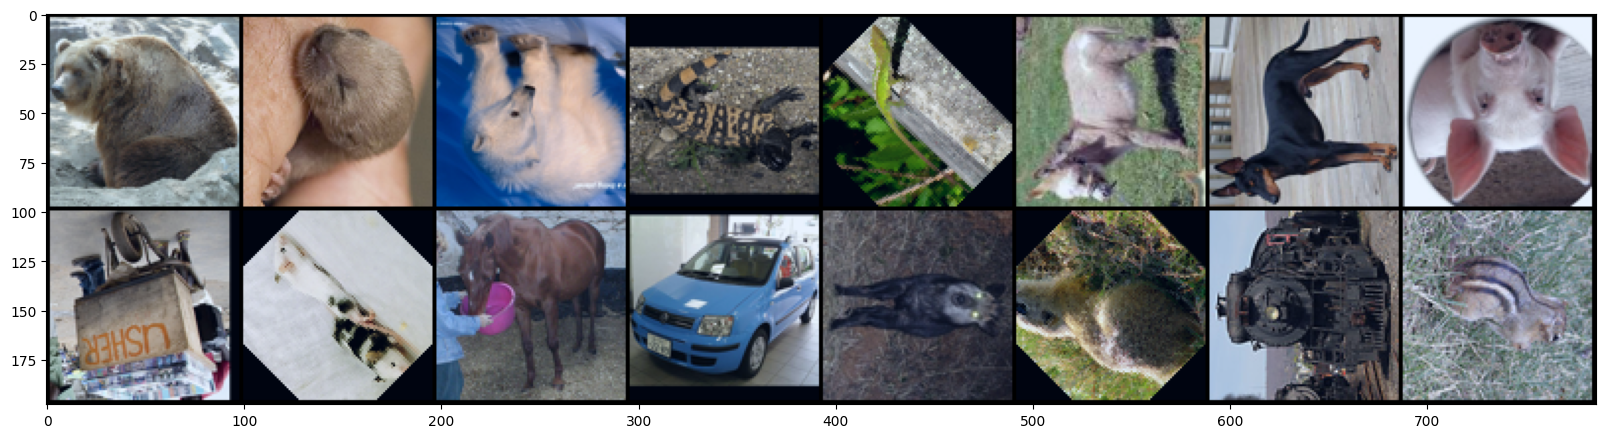

In [13]:
plt.figure(figsize = (20,10))
images, labels = next(iter(model_trainer.train_loader))
out = torchvision.utils.make_grid(images[0:16], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [14]:
# Lets see how many Parameter's our Model has!
num_params = 0
for param in model_trainer.model.parameters():
    num_params += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (num_params, num_params//1e6))

This model has 11180103 (approximately 11 Million) Parameters!


# Train Model!
Our full training method is now fully contained within the trainner class! Simply run the run_training method and specify how many epochs it should train for!

In [15]:
model_trainer.run_training(num_epochs=num_epochs)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

# View Results

In [16]:
print("The highest validation accuracy was %.2f%%" %(model_trainer.best_valid_acc*100))

The highest validation accuracy was 84.75%


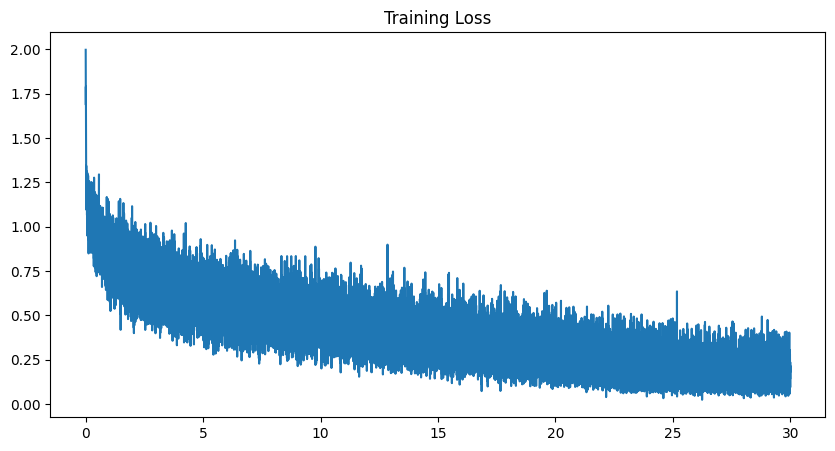

In [17]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_loss_logger))
_ = plt.plot(train_x, model_trainer.train_loss_logger)
_ = plt.title("Training Loss")

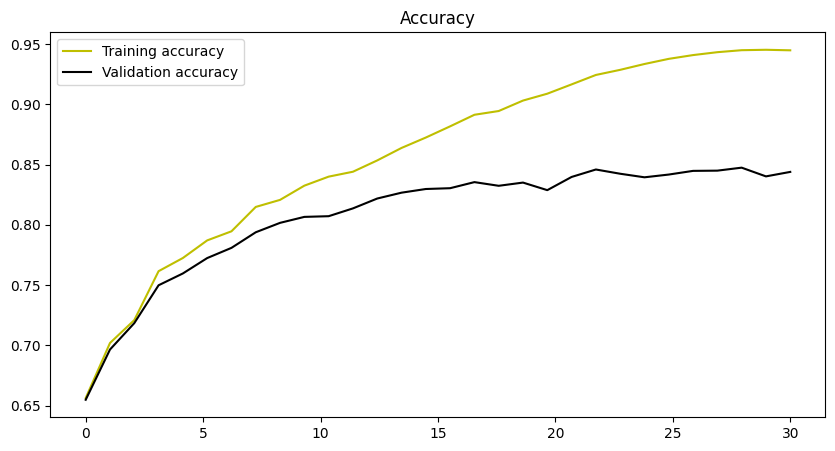

In [18]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_acc_logger))
_ = plt.plot(train_x, model_trainer.train_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model_trainer.val_acc_logger))
_ = plt.plot(valid_x, model_trainer.val_acc_logger, c = "k")

_ = plt.title("Accuracy")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [19]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = model_trainer.evaluate_model(train_test_val="test")
print("The Test Accuracy is: %.2f%%" %(test_acc*100))

Evaluating Test Set:   0%|          | 0/125 [00:00<?, ?it/s]

The Test Accuracy is: 94.08%
